In this notebook we explore key data observations in Calibrations X7-12 (Gaussian field) and XU7-12 (uniform field).

In [1]:
from qslamdesignparams import GLOBALDICT
from riskanalysis import CreateQslamExpt as riskqslam
from riskanalysis import NaiveEstimator

import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
import traceback

## Exploring RMS saturation in the long measurement limit

### Insight 1: Low Forgetting Factors should enable convergence to the truth

One observation is that all RMS error seems to saturate around a value of 1/2. The observation holds true for all types of parameter regimes except msmt_per_node. This leads me to believe that it's a long run bias that has been introduced, or a programming error. To test this, we set the forgetting factors for different values of iterations. The rate of converge to the truth then depends on the value of the forgetting factors - a low value means that we switch off the smart part of the algorithm sooner. For forgetting factors close to zero, the algorithm should approach the true in the large measurement limit.


#### Update Default Settings

In [2]:
change_MAX_NUM_ITERATIONS = 100
change_MSMTS_PER_NODE = 5
change_P_ALPHA = 5 #25
change_P_BETA = 3 #10
change_SIGMOID_APPROX_ERROR = 10.0**(-6)
change_QUANTISATION_UNCERTY = 10.0**(-4)
change_LAMBDA_1 = 0.7
change_LAMBDA_2 = 0.7


In [3]:
GLOBALDICT["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = change_MAX_NUM_ITERATIONS
GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = change_MSMTS_PER_NODE
GLOBALDICT["NOISEPARAMS"]["SIGMOID_APPROX_ERROR"]["SIGMA"] = change_SIGMOID_APPROX_ERROR
GLOBALDICT["NOISEPARAMS"]["QUANTISATION_UNCERTY"]["SIGMA"] = change_QUANTISATION_UNCERTY
GLOBALDICT["MODELDESIGN"]["P_ALPHA"] = change_P_ALPHA
GLOBALDICT["MODELDESIGN"]["P_BETA"] = change_P_BETA
GLOBALDICT["MODELDESIGN"]["LAMBDA_1"] = change_LAMBDA_1
GLOBALDICT["MODELDESIGN"]["LAMBDA_2"] = change_LAMBDA_2

#### Xplay: Gaussian Field

Measurement Iterations:  5


/home/riddhisw/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


Variation  1 successful.


particlesets.py:162: RuntimeWarning: overflow encountered in double_scalars
  normalisation = 1.0/unnormalised_total
particlesets.py:163: RuntimeWarning: invalid value encountered in multiply
  return normalisation*raw_weights


Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  25
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  50
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  75
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  100
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5

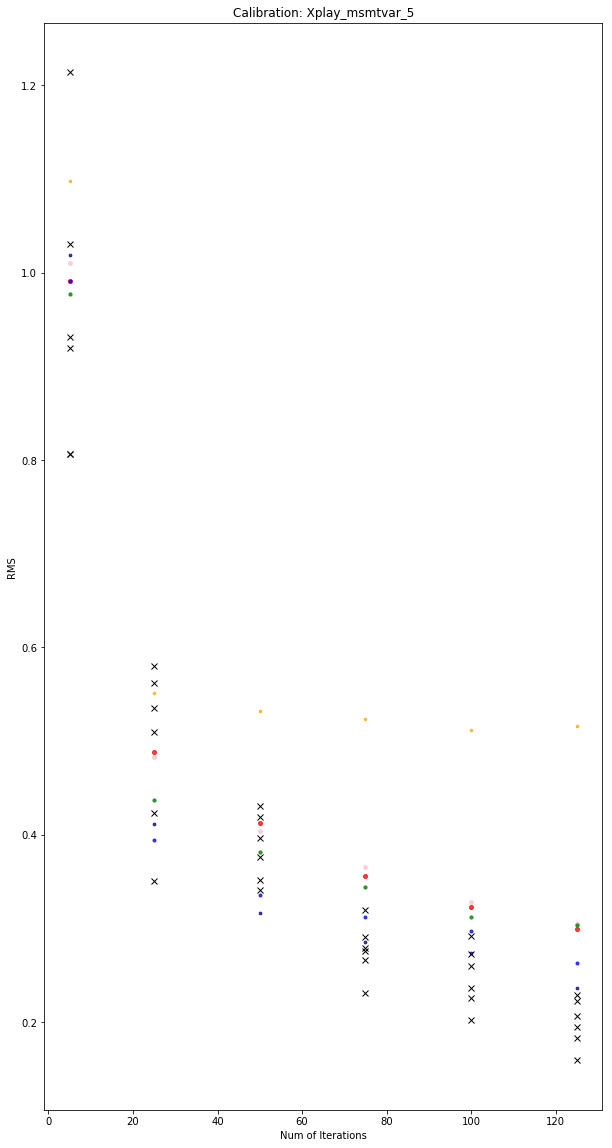

In [4]:
MAPTYPE = 'Gaussian'

msmt_param_scan = [5, 25, 50, 75, 100, 125]
var_param_x7 = [0., 0.25, 0.5, 0.75, 0.9, 1.0] 
colorvar = ['r', 'pink', 'g', 'b', 'navy', 'orange']
size_var = [4, 3.75, 3.25, 3.0, 2.75, 2.5]

# [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]


savetopath = './calibrations_data/'

plt.figure(figsize=(10,20))
    
for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'Xplay' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x7 = np.zeros(len(var_param_x7))
    emp_err_x7 = np.zeros(len(var_param_x7))


    for idx_var in range(len(var_param_x7)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["MODELDESIGN"]["LAMBDA_1"] = var_param_x7[idx_var]
        vardict["MODELDESIGN"]["LAMBDA_2"] = var_param_x7[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x7[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            # plt.plot(var_param_x7[idx_var], var_err_x7[idx_var], 'ko')
            plt.plot(msmt_param_scan[idx_msmtvar], var_err_x7[idx_var], 'o', 
                     c=colorvar[idx_var], alpha=0.75,
                     markersize=size_var[idx_var])

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x7[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        # plt.plot(var_param_x7[idx_var], emp_err_x7[idx_var], 'rx')
        plt.plot(msmt_param_scan[idx_msmtvar], emp_err_x7[idx_var], 'kx')
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print
    
plt.title('Calibration: ' + testcase_ID)
plt.ylabel('RMS')
plt.xlabel('Num of Iterations')
# plt.xscale('log')
# plt.ylim([0, 1])
plt.show()  

#### Xplay: Uniform Field

Measurement Iterations:  5
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  25
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  50
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  75
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
------ completed a measurement iteration -----



Measurement Iterations:  100
Variation  1 successful.
Variation  2 successful.
Variation 

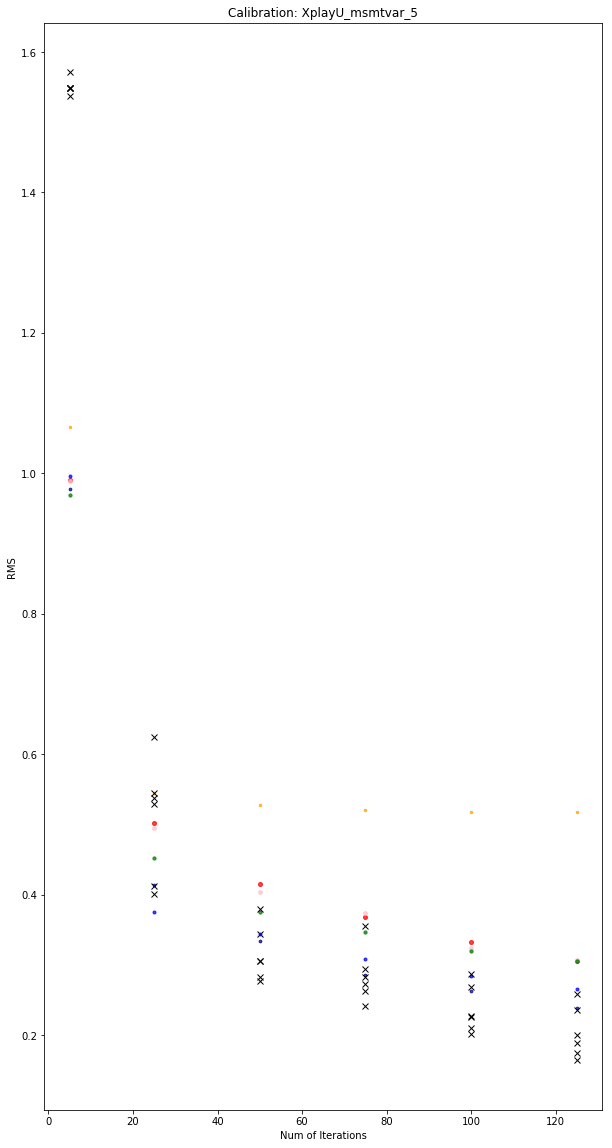

In [5]:
MAPTYPE = 'Uniform'

msmt_param_scan = [5, 25, 50, 75, 100, 125]
var_param_x7 = [0., 0.25, 0.5, 0.75, 0.9, 1.0] 
colorvar = ['r', 'pink', 'g', 'b', 'navy', 'orange']
size_var = [4, 3.75, 3.25, 3.0, 2.75, 2.5]

# [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]


savetopath = './calibrations_data/'

plt.figure(figsize=(10,20))
    
for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'XplayU' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x7 = np.zeros(len(var_param_x7))
    emp_err_x7 = np.zeros(len(var_param_x7))


    for idx_var in range(len(var_param_x7)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["MODELDESIGN"]["LAMBDA_1"] = var_param_x7[idx_var]
        vardict["MODELDESIGN"]["LAMBDA_2"] = var_param_x7[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x7[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            # plt.plot(var_param_x7[idx_var], var_err_x7[idx_var], 'ko')
            plt.plot(msmt_param_scan[idx_msmtvar], var_err_x7[idx_var], 'o', 
                     c=colorvar[idx_var], alpha=0.75,
                     markersize=size_var[idx_var])

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x7[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        # plt.plot(var_param_x7[idx_var], emp_err_x7[idx_var], 'rx')
        plt.plot(msmt_param_scan[idx_msmtvar], emp_err_x7[idx_var], 'kx')
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print
    
plt.title('Calibration: ' + testcase_ID)
plt.ylabel('RMS')
plt.xlabel('Num of Iterations')
# plt.xscale('log')
# plt.ylim([0, 1])
plt.show()  

The results of the X-Series Calibrations also suggest that the following values of the forgetting factors produce a strong dip in RMS Error

   LAMBDA_1 = 0.82
   
   LAMBDA_1 = 0.968

This is supported by the analysis above that an incorrect choice of forgetting factor leads to an aysmpotic bias for any parameter regime.

## Other Observations

###  Handling Invalid Posterior Resampling  / Weight Reset 

We need to characterise the effect of resetting invalid posterior distributions to uniform weights without resampling. One way to do this is to compare the above results with the case when invalid Posterior distributions result in RunTime errors. We then compare if there is a bias in convergence and whether its possible to remove this bias through:

    (a) Abandoning the run and calling Initialise particles() instead of setting weights to uniform 
    (b) Resampling or setting weights according to a new adaptive procedure (needs literature review)
    


### Making control functions comparable between Naive and Qslam estimators might remove the asympotic offset bias

In qslamr, with quasi-msmt factors being switched off via forgetting factors, there is still a uniform sampling over possible control directives. In constrast, teh Naive Estimator measures all qubits sequentially. This, as well as a variety of initial distribution conditions in qslamr, might explain the asympotic offset between measuring the field at all locations perfectly and the output of the qslamr algorithm.

### Large Alpha particles should enable faster convergence to the truth

One feature should be that a large number of particles should enable faster convergence to the truth and/or a greater "win" in the sparse measurement regime.

### Compare performance with smaller measurement budgets

We need to examine performance with smaller measurement budgets, for example, when you cannot measue all qubits or you can only measure all qubits once. qslam should win in smaller measurement budget regimes and it will be important to confirm this if a asymptotic offset exists in the large measurement limit